In [3]:
import numpy as np
import matplotlib.pyplot as plt
import msprime
from IPython.display import SVG, display

In [4]:
import tskit

In [7]:
msprime.__version__

'0.7.0'

In [188]:
def get_sfs(sample_size, model, num_replicates=1000):
    
    branch_lengths = np.zeros((num_replicates, sample_size-1))
    
    reps = msprime.simulate(sample_size, num_replicates=num_replicates, model=model)
    for i, ts in enumerate(reps):
        calculator = tskit.BranchLengthStatCalculator(ts)
        sample_set = list(range(sample_size))
        branch_lengths[i,:] = calculator.site_frequency_spectrum(sample_set)[0][:-1]
    return branch_lengths


In [214]:
def get_windowed_sfs(sample_size, model, length=100, **kwargs):
    
#     branch_lengths = np.zeros((length, sample_size-1))
    
    sim = next(msprime.simulate(sample_size, num_replicates=1, model=model, length=length, **kwargs))
    calculator = tskit.BranchLengthStatCalculator(sim)
    windows = np.arange(0, length+1)
    sample_set = list(range(sample_size))
    branch_lengths = np.array(calculator.site_frequency_spectrum(sample_set, windows=windows))[:,:-1]
    return branch_lengths


In [73]:
def pairwise_diversity(allele_counts, sample_size):
    f = allele_counts / sample_size
    return 2*f*(1-f) / (1 - (1/sample_size))

def eta2pi(sfs, sample_size):
    counts = np.arange(1, sample_size//2 + 1)
    pi_weights = pairwise_diversity(counts, sample_size)
    return pi_weights.dot(sfs)

In [6]:
def cross_correlation(X, Y, lim):
    n_comps = X.shape[0] - lim
    xy = np.correlate(X, Y[:-lim], 'valid') / n_comps
    x = np.convolve(X, np.ones(n_comps), 'valid') / n_comps
    y = np.nansum(Y[:-lim]) / n_comps
    return (xy - x*y)

In [78]:
def folded(sfs, sample_size):
    sfs_fold = (sfs + sfs[...,::-1])[...,:sample_size//2]
    if sample_size % 2 == 0:
        sfs_fold[...,-1] /= 2
    return sfs_fold

In [189]:
# Reset seed
np.random.seed(100)

n = 39
num_reps = 10000

alphas = [1.0, 1.25, 1.5, 1.75]
psis = [0.0625, 0.125, 0.25, 0.5]

sfs_dict = {}
sfs_dict['kingman'] = get_sfs(n, msprime.StandardCoalescent(), num_reps)
for alpha in alphas:
    sfs_dict[('beta', alpha)] = get_sfs(n, msprime.BetaCoalescent(alpha=alpha), num_reps)
for psi in psis:
    sfs_dict[('dirac', psi)] = get_sfs(n, msprime.DiracCoalescent(1, psi, 1), num_reps)


In [190]:
keys = sfs_dict.keys()

In [191]:
xi_dict = {}
eta_dict = {}
pi_dict = {}
for key in keys:
    xi_dict[key] = np.mean(sfs_dict[key], axis=0)
    folded_sfs = folded(sfs_dict[key], n)
    eta_dict[key] = np.mean(folded_sfs, axis=0)
    pi_dict[key] = eta2pi(eta_dict[key], n)

In [192]:
for key in keys:
    print(key, pi_dict[key])

kingman 3.9821971321096297
('beta', 1.0) 3.524197908230773
('beta', 1.25) 3.508920404107833
('beta', 1.5) 3.51664727464157
('beta', 1.75) 3.597857469014795
('dirac', 0.0625) 3.9995085090410476
('dirac', 0.125) 3.882032264530614
('dirac', 0.25) 3.5732537817162298
('dirac', 0.5) 2.9378489178472957


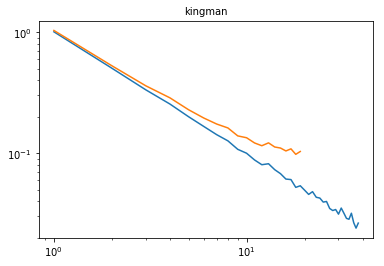

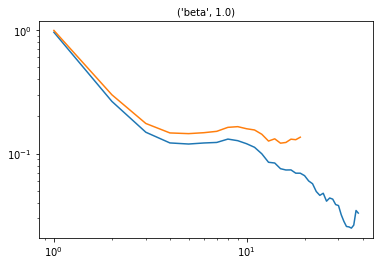

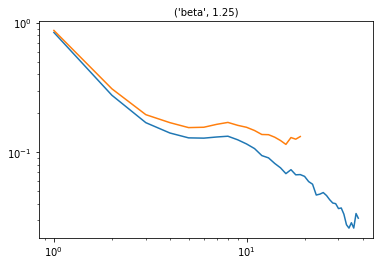

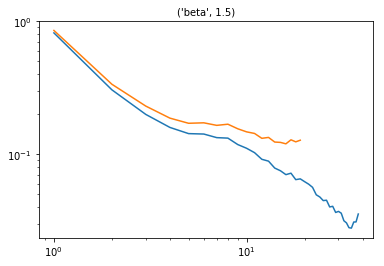

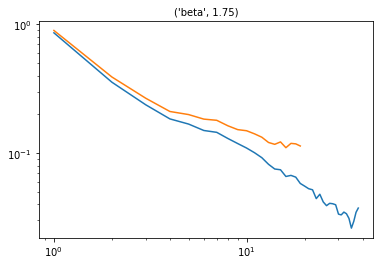

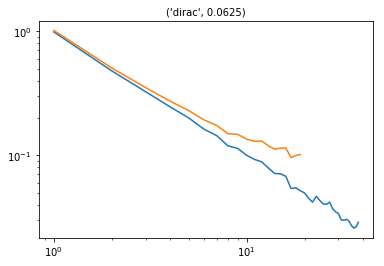

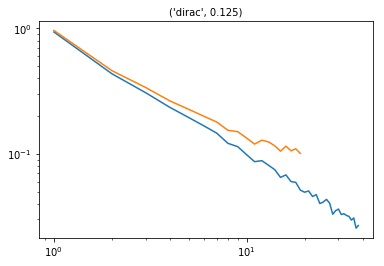

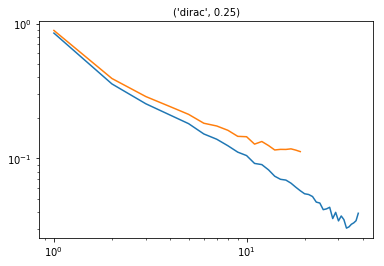

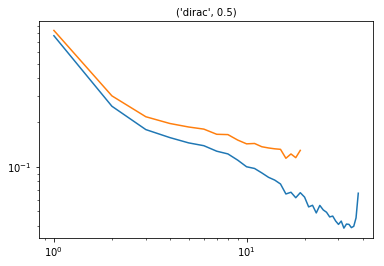

In [193]:
for key in keys:
    plt.loglog(np.arange(1,n), xi_dict[key]/pi_dict[key])
    plt.loglog(np.arange(1,n//2+1), eta_dict[key]/pi_dict[key])
    plt.title(key)
    plt.show()

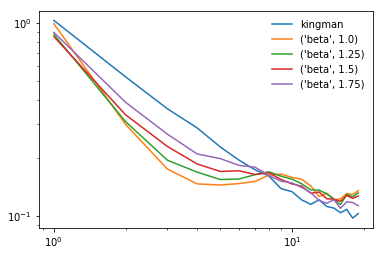

In [194]:
for key in keys:
    if key == 'kingman' or key[0] == 'beta':
        plt.loglog(np.arange(1,n//2+1), eta_dict[key]/pi_dict[key], label=key)
plt.legend()

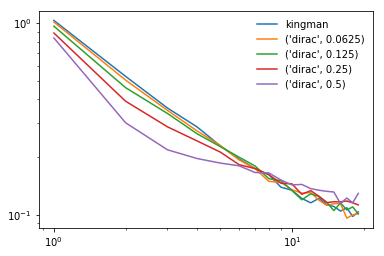

In [195]:
for key in keys:
    if key == 'kingman' or key[0] == 'dirac':
        plt.loglog(np.arange(1,n//2+1), eta_dict[key]/pi_dict[key], label=key)
plt.legend()

In [196]:
twosfs_dict = {}
fpmi_dict = {}
wfpmi_dict = {}
for key in keys:
    sfs_fold = folded(sfs_dict[key], n)
    twosfs_dict[key] = np.mean(sfs_fold[:,:,None]*sfs_fold[:,None,:] ,axis=0)
    fpmi_dict[key] = np.log2(twosfs_dict[key] / (eta_dict[key][:,None]*eta_dict[key][None,:]))
    fpmi_dict[key][np.diag_indices_from(fpmi)] = 0
    wfpmi_dict[key] = fpmi_dict[key]*twosfs_dict[key] / pi_dict[key]**2

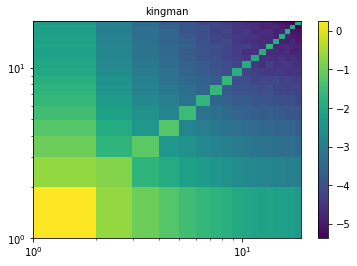

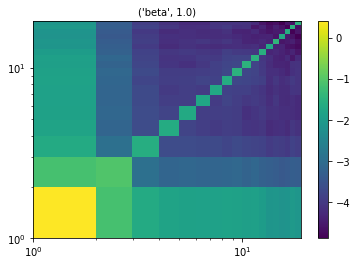

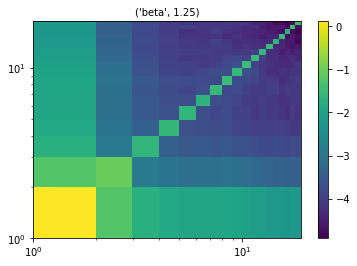

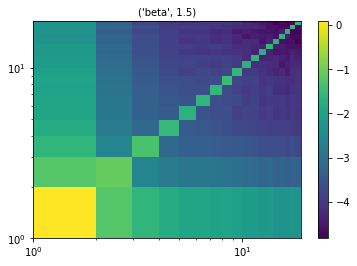

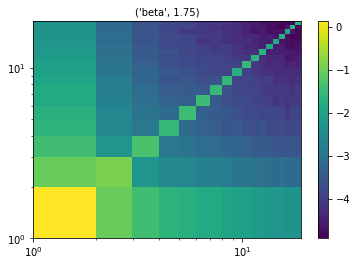

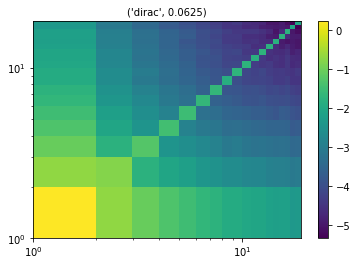

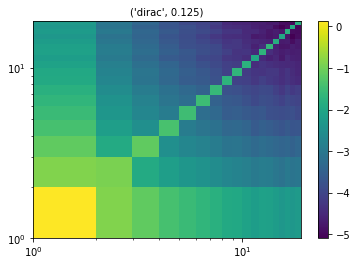

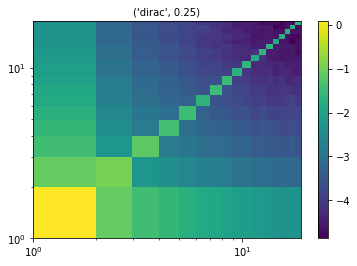

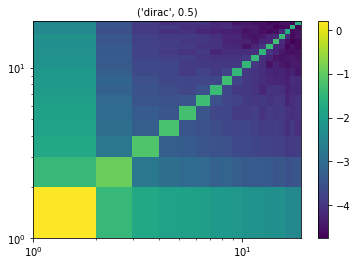

In [197]:
for key in keys:
    plt.pcolormesh(np.arange(1,n//2+1), np.arange(1,n//2+1), np.log(twosfs_dict[key]/pi_dict[key]**2))
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar()
    plt.title(key)
    plt.show()

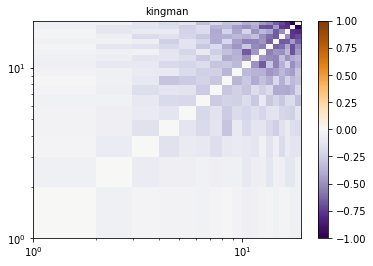

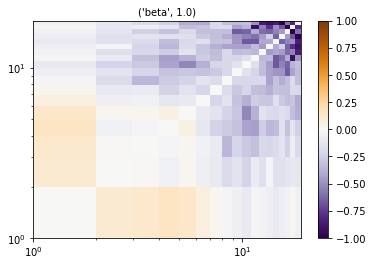

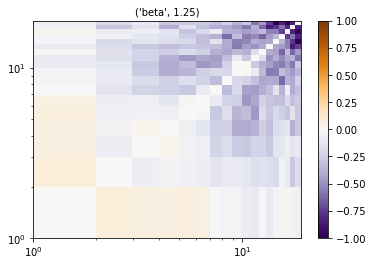

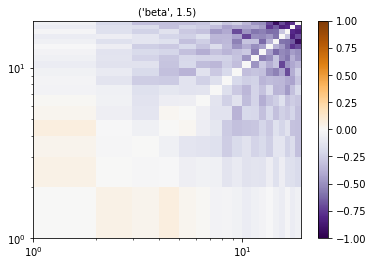

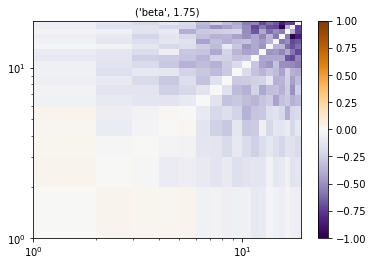

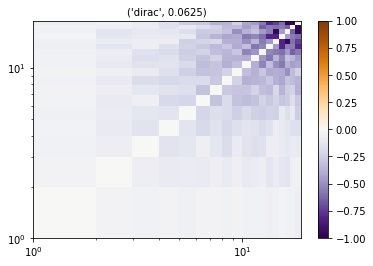

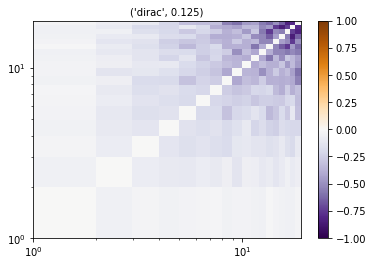

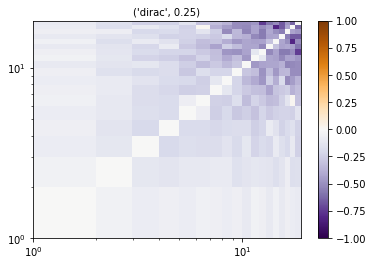

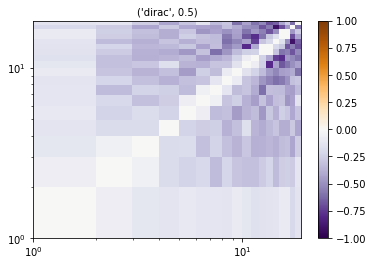

In [198]:
for key in keys:
    plt.pcolormesh(np.arange(1,n//2+1), np.arange(1,n//2+1), fpmi_dict[key], cmap='PuOr_r', vmin=-1,vmax=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar()
    plt.title(key)
    plt.show()

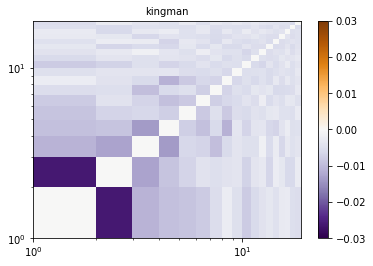

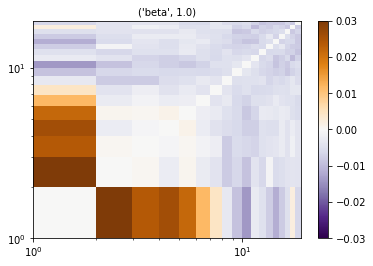

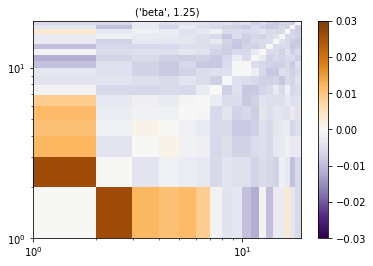

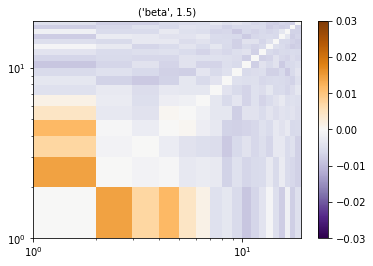

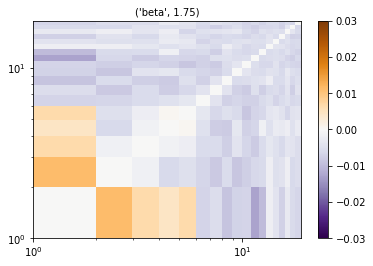

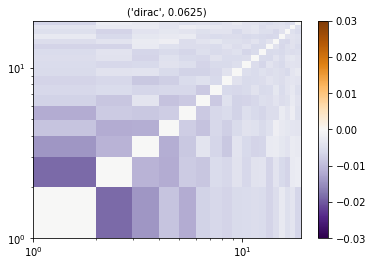

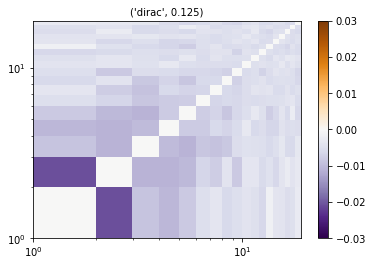

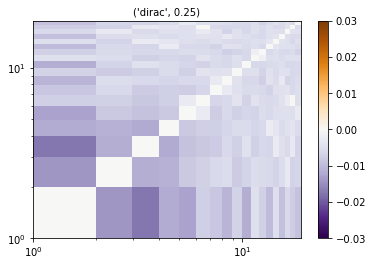

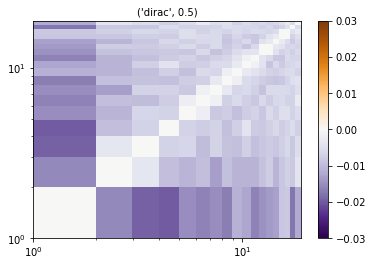

In [199]:
for key in keys:
    plt.pcolormesh(np.arange(1,n//2+1), np.arange(1,n//2+1), wfpmi_dict[key], cmap='PuOr_r', vmin=-0.03,vmax=0.03)
    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar()
    plt.title(key)
    plt.show()

In [200]:
cutoffs = np.arange(1,n//2)
hlp_dict = {}
for key in keys:
    hlp = np.zeros_like(cutoffs,dtype='float')
    eta = eta_dict[key]
    twosfs = twosfs_dict[key]
    for i, co in enumerate(cutoffs):
        lo = np.sum(eta[:co])
        hi = np.sum(eta[co:])
        hilo = np.sum(twosfs[:co,co:])
        hlp[i] = np.log2(hilo/(hi*lo))
    hlp_dict[key] = hlp

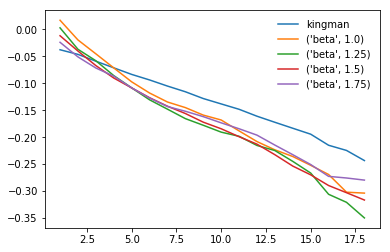

In [201]:
for key in keys:
    if key == 'kingman' or key[0] == 'beta':
        plt.plot(cutoffs, hlp_dict[key], label=key)
plt.legend()

In [202]:
mlp_dict = {}
for key in keys:
    mlp = np.zeros_like(cutoffs,dtype='float')
    eta = eta_dict[key]
    twosfs = twosfs_dict[key]
    for i, co in enumerate(cutoffs):
        lo = eta[0]
        med = np.sum(eta[1:co])
        medlo = np.sum(twosfs[0,1:co])
        mlp[i] = np.log2(medlo/(med*lo))
    mlp_dict[key] = mlp

/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


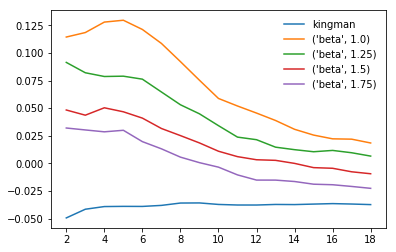

In [203]:
for key in keys:
    if key == 'kingman' or key[0] == 'beta':
        plt.plot(cutoffs, mlp_dict[key], label=key)
plt.legend()

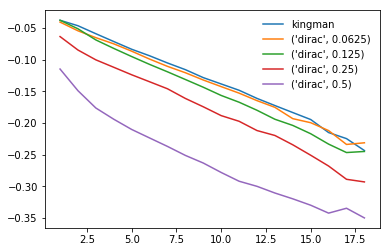

In [204]:
for key in keys:
    if key == 'kingman' or key[0] == 'dirac':
        plt.plot(cutoffs, hlp_dict[key], label=key)
plt.legend()

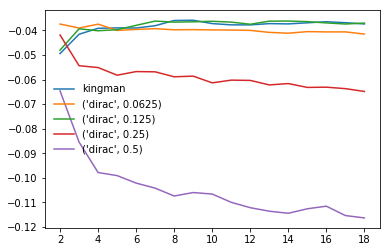

In [205]:
for key in keys:
    if key == 'kingman' or key[0] == 'dirac':
        plt.plot(cutoffs, mlp_dict[key], label=key)
plt.legend()

## Trees

2.0 0


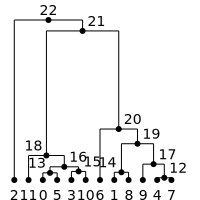

2.0 1


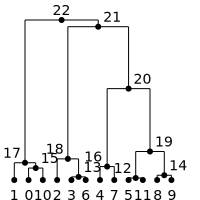

2.0 2


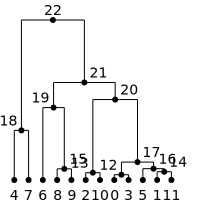

2.0 3


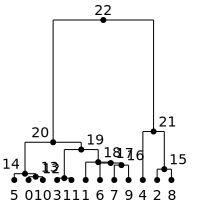

2.0 4


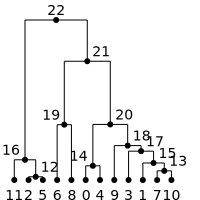

1.5 0


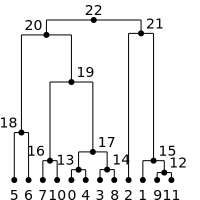

1.5 1


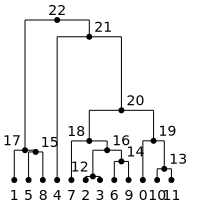

1.5 2


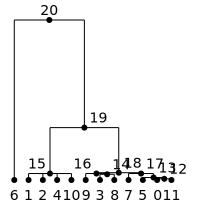

1.5 3


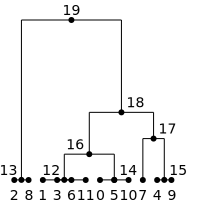

1.5 4


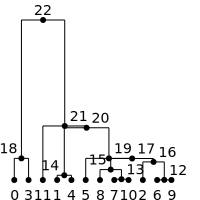

1.0 0


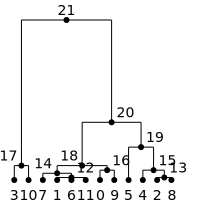

1.0 1


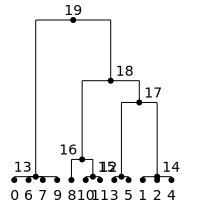

1.0 2


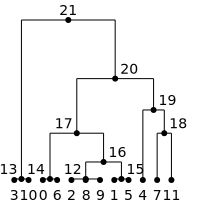

1.0 3


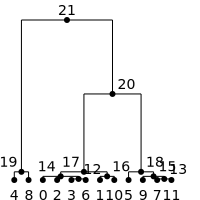

1.0 4


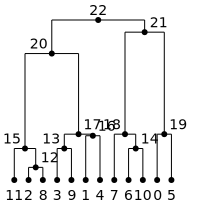

In [26]:
sample_size = 12
num_replicates = 5
alphas = [2.0, 1.5, 1.0]

np.random.seed(100)
for alpha in alphas:
    if alpha == 2.0:
        model=msprime.StandardCoalescent()
    else:
        model=msprime.BetaCoalescent(alpha=alpha)
    reps = msprime.simulate(sample_size, num_replicates=num_replicates, model=model)
    for i, rep in enumerate(reps):
        print(alpha, i)
        display(SVG(next(rep.trees()).draw()))
        

0.01 1e-06 0


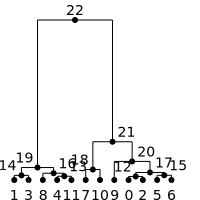

0.01 1e-06 1


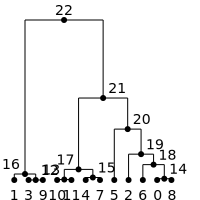

0.01 1e-06 2


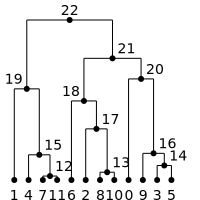

0.01 1e-06 3


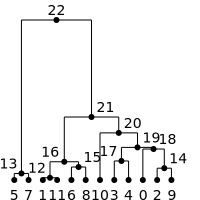

0.01 1e-06 4


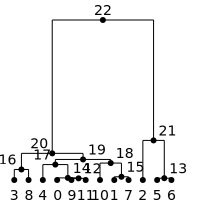

0.01 1.0 0


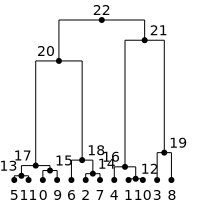

0.01 1.0 1


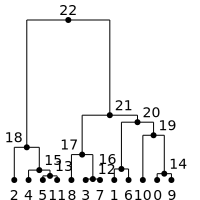

0.01 1.0 2


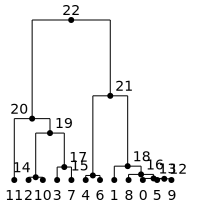

0.01 1.0 3


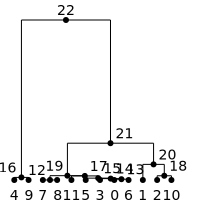

0.01 1.0 4


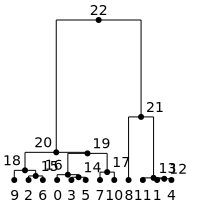

0.01 100.0 0


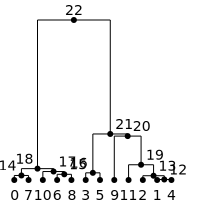

0.01 100.0 1


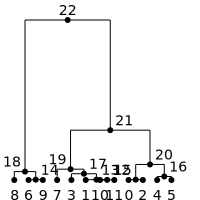

0.01 100.0 2


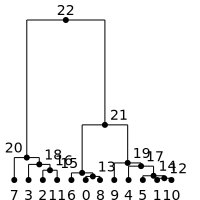

0.01 100.0 3


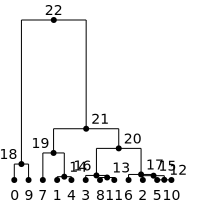

0.01 100.0 4


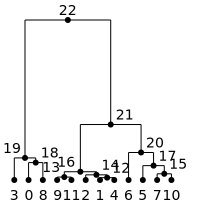

0.5 1e-06 0


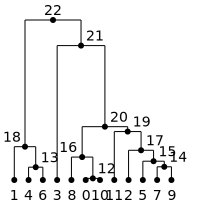

0.5 1e-06 1


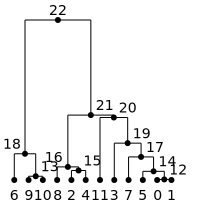

0.5 1e-06 2


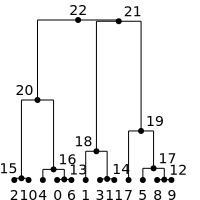

0.5 1e-06 3


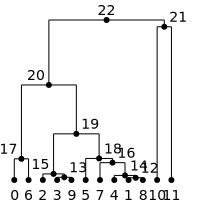

0.5 1e-06 4


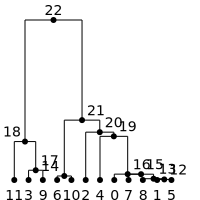

0.5 1.0 0


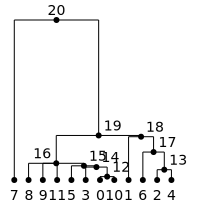

0.5 1.0 1


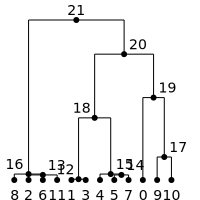

0.5 1.0 2


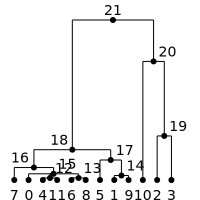

0.5 1.0 3


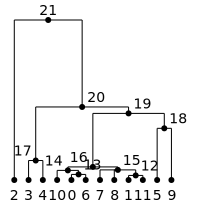

0.5 1.0 4


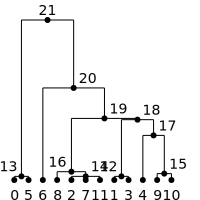

0.5 100.0 0


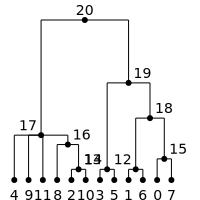

0.5 100.0 1


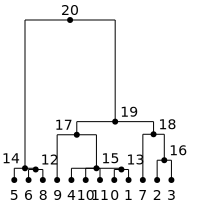

0.5 100.0 2


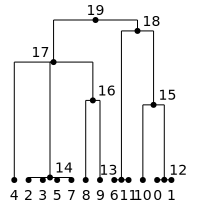

0.5 100.0 3


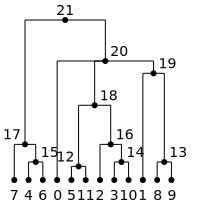

0.5 100.0 4


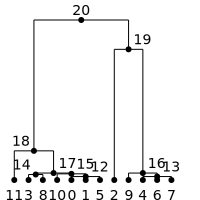

0.99 1e-06 0


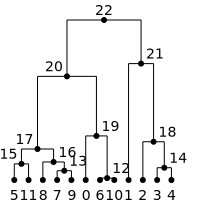

0.99 1e-06 1


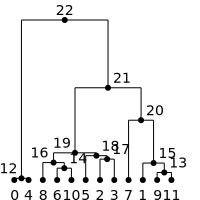

0.99 1e-06 2


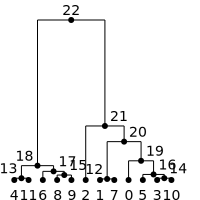

0.99 1e-06 3


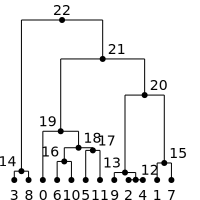

0.99 1e-06 4


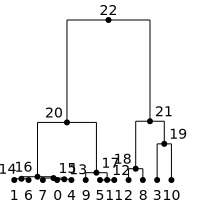

0.99 1.0 0


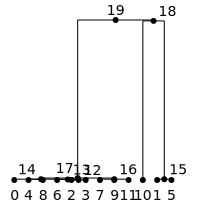

0.99 1.0 1


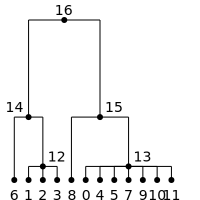

0.99 1.0 2


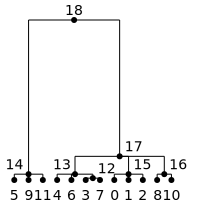

0.99 1.0 3


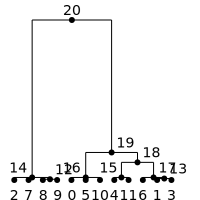

0.99 1.0 4


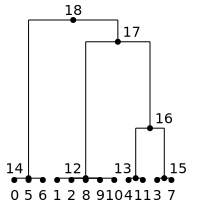

0.99 100.0 0


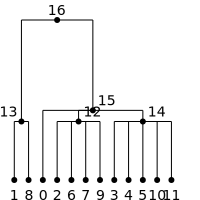

0.99 100.0 1


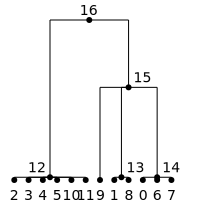

0.99 100.0 2


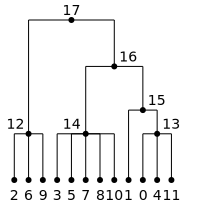

0.99 100.0 3


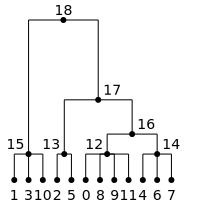

0.99 100.0 4


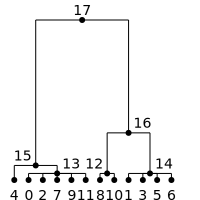

In [27]:
sample_size = 12
num_replicates = 5
psi_list = [0.01, 0.5, 0.99]
c_list = [1e-6, 1.0, 1e2]
N = 10

np.random.seed(100)

for psi in psi_list:
    for c in c_list:
        model=msprime.DiracCoalescent(N, psi, c)
        reps = msprime.simulate(sample_size, num_replicates=num_replicates, model=model)
        for i, rep in enumerate(reps):
            print(psi, c, i)
            display(SVG(next(rep.trees()).draw()))
        

## Recombination

In [231]:
length = 100000

In [232]:
sim = get_windowed_sfs(n, msprime.StandardCoalescent(), length=length, recombination_rate=0.1)

In [255]:
sim2 = get_windowed_sfs(n, msprime.StandardCoalescent(), length=length, recombination_rate=0.1)

In [260]:
sim3 = get_windowed_sfs(n, msprime.BetaCoalescent(alpha=1.5), length=length, recombination_rate=0.1)

In [263]:
sim4 = get_windowed_sfs(n, msprime.BetaCoalescent(alpha=1.5), length=length, recombination_rate=0.1)

In [331]:
sim5 = get_windowed_sfs(n, msprime.BetaCoalescent(alpha=1.5), length=length, recombination_rate=0.1)

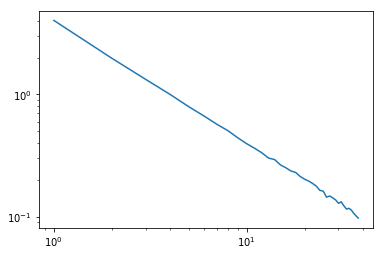

In [233]:
plt.loglog(np.arange(1,n), np.mean(sim, axis=0))

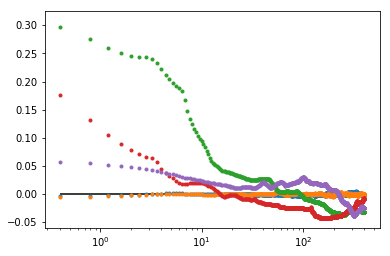

In [334]:
cutoff = 2
for s in [sim, sim2, sim3, sim4, sim5]:
    x = np.sum(s[:, :cutoff], axis=1)
    y = np.sum(s[:-l_max, cutoff:], axis=1)
    z = np.correlate(x, y, mode='valid') / (length-l_max)
    x_mean = np.correlate(x, np.ones(length-l_max), 'valid') / (length-l_max)
    plt.semilogx(np.arange(1001)*4*0.1, np.log2(z/(x_mean*np.mean(y))), '.')
plt.hlines(0, 0.4, 400)

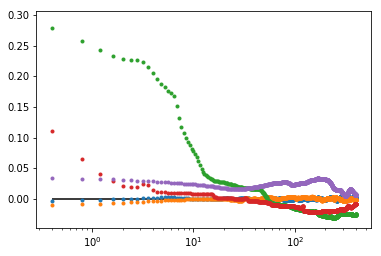

In [335]:
cutoff = 1
for s in [sim, sim2, sim3, sim4, sim5]:
    x = np.sum(s[:, :cutoff], axis=1)
    y = np.sum(s[:-l_max, cutoff:], axis=1)
    z = np.correlate(x, y, mode='valid') / (length-l_max)
    x_mean = np.correlate(x, np.ones(length-l_max), 'valid') / (length-l_max)
    plt.semilogx(np.arange(1001)*4*0.1, np.log2(z/(x_mean*np.mean(y))), '.')
plt.hlines(0, 0.4, 400)

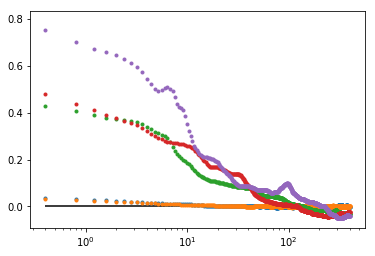

In [332]:
cutoff = 10
for s in [sim, sim2, sim3, sim4, sim5]:
    x = np.sum(s[:, :cutoff], axis=1)
    y = np.sum(s[:-l_max, cutoff:], axis=1)
    z = np.correlate(x, y, mode='valid') / (length-l_max)
    x_mean = np.correlate(x, np.ones(length-l_max), 'valid') / (length-l_max)
    plt.semilogx(np.arange(1001)*4*0.1, np.log2(z/(x_mean*np.mean(y))), '.')
plt.hlines(0, 0.4, 400)